### Code For Final Project

Loading libraries

In [1]:
import pandas as pd
import numpy as np
import requests
!conda install -c conda-forge bs4 --yes 
from bs4 import BeautifulSoup
import os
!conda install -c conda-forge folium=0.5.0 --yes
import folium 
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns
print('Done!')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - bs4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.9.1       |   py36h9f0ad1d_0         163 KB  conda-forge
    bs4-4.9.1                  |                0           4 KB  conda-forge
    soupsieve-2.0.1            |   py36h9f0ad1d_0          56 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         223 KB

The following NEW packages will be INSTALLED:

  beautifulsoup4     conda-forge/linux-64::beautifulsoup4-4.9.1-py36h9f0ad1d_0
  bs4                conda-forge/noarch::bs4-4.9.1-0
  soupsieve          conda-forge/linux-64::soupsieve-2.0.1-py36h9f0ad1d_0



beautifulsoup4-4.9.1 | 163 KB    | ##################################### | 100% 
bs4-4.9.1 

My Variables

In [2]:
CLIENT_ID = 'Z45YDXHCZXSDW0VSQIOHZTKNIMC4XCZMR54RMSGFQTWDCH1Q' # your Foursquare ID
CLIENT_SECRET = '1REXN2M4XS4C5EJPP4BLZQYGBNDNNDE2DDVFWV2EBLHYJRAI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Z45YDXHCZXSDW0VSQIOHZTKNIMC4XCZMR54RMSGFQTWDCH1Q
CLIENT_SECRET:1REXN2M4XS4C5EJPP4BLZQYGBNDNNDE2DDVFWV2EBLHYJRAI


Functions that will be used later

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

use the above codes to get our initial NYC data

In [4]:
ny_data = get_new_york_data()
ny_data.head()



,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
ny_data.shape

(306, 4)

Now that we have our initial data, lets start analyzing it. We can see below that Manhattan has the least number of neighborhoods in all five buroughs.

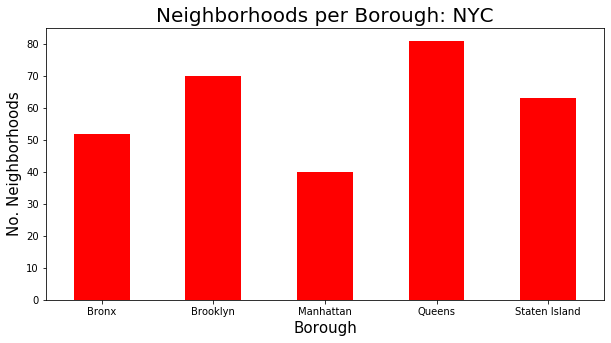

In [6]:
clr = "red"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

Lets analyze further and see how many italian restaurants there are in each neighborhood and burough and graph the results.

In [7]:
# queens has most neighborhoods
# prepare neighborhood list that contains italian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_resturants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(ny_data),')','Italian Resturants in '+Neighborhood+', '+Borough+':'+str(len(italian_resturants)))
    print(row)
    for resturant_detail in italian_resturants.values.tolist():
        id, name , category=resturant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Italian Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Italian Resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Italian Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Italian Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Italian Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Italian Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Italian Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Italian Resturants in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Italian Resturants in Norwood, Bronx:0
['Bronx', '

In [8]:
italian_rest_ny.to_csv('italian_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare

In [9]:
italian_rest_ny = pd.read_csv('italian_rest_ny_tocsv1.csv',index_col=0)
italian_rest_ny.tail()

,Borough,Neighborhood,ID,Name
230,Queens,Sunnyside Gardens,5699aa86498ef437b2fd7102,Zio Luigi
231,Brooklyn,Fulton Ferry,593c0d2262420b7feccc3048,Cecconi's
232,Brooklyn,Dumbo,593c0d2262420b7feccc3048,Cecconi's
233,Staten Island,Prince's Bay,4c091311a1b32d7f5efb96f0,Certo's Gourmet Foods & Caterers
234,Staten Island,Lighthouse Hill,5079ccdce4b065f1dd8155ad,Casa verde


In [10]:
italian_rest_ny.shape

(235, 4)

As we continue our analysis, we see below that although Manhattan had the least number of nieghborhoods, it does have the highest number if Italian restaurants. Additionally, we see how many restaurants the top 6 neighborhoods have. The neighborhood of Belmont has the highest number of Italian restaurants in all of NYC and is actually located in the burough of Bronx vice Manhattan.

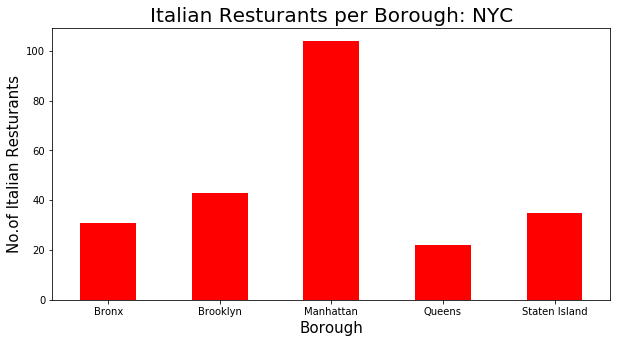

In [11]:
italian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Italian Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Italian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

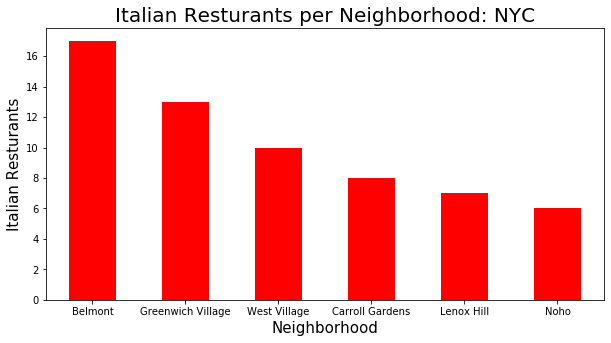

In [12]:
NOofNeigh = 6 # top number for graphing all the same past 6
italian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Italian Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Italian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [13]:
italian_rest_ny[italian_rest_ny['Neighborhood']=='Belmont']

,Borough,Neighborhood,ID,Name
7,Bronx,Belmont,4acf80aef964a52025d420e3,Tino's Delicatessen
8,Bronx,Belmont,4af71916f964a520cf0522e3,Michaelangelo's Coal Fired Brick Oven Pizza Re...
9,Bronx,Belmont,59050f51b23dfa5f6649e678,Arthur Avenue Fiasco
10,Bronx,Belmont,4bb6470cef159c7465b275f7,Calabria Pork Store
11,Bronx,Belmont,4c9b9e7b9c663704b90463fd,Gerbasi Ristorante
12,Bronx,Belmont,4aa425bef964a5208e4520e3,Dominick's Restaurant
13,Bronx,Belmont,4b5514c4f964a5207cda27e3,Enzo's
14,Bronx,Belmont,4af0fa29f964a52060e021e3,Antonio's Trattoria
15,Bronx,Belmont,4b5a4c8ff964a52049bb28e3,Emilia's Restaurant
16,Bronx,Belmont,4aa193d5f964a520124120e3,Mario's Restaurant & Catering


In [ ]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in italian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
italian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5f0963d7cd5ad5087399f827'}, 'response': {'venue': {'id': '511edb6de4b0d58346fd272d', 'name': "Patrizia's Of Woodlawn", 'contact': {'phone': '7188845700', 'formattedPhone': '(718) 884-5700'}, 'location': {'address': '4358 Katonah Ave', 'lat': 40.900638399332884, 'lng': -73.86772361835486, 'labeledLatLngs': [{'label': 'display', 'lat': 40.900638399332884, 'lng': -73.86772361835486}, {'label': 'entrance', 'lat': 40.900601, 'lng': -73.867611}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4358 Katonah Ave', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/patrizias-of-woodlawn/511edb6de4b0d58346fd272d', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}],

In [15]:
italian_rest_stats_ny.to_csv('italian_rest_stats_ny_csv.csv') # I continue to save data to a .csv as I move through this project

In [16]:
italian_rest_stats_ny.shape

(235, 7)

In [17]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       235 non-null    object 
 1   Neighborhood  235 non-null    object 
 2   ID            235 non-null    object 
 3   Name          235 non-null    object 
 4   Likes         235 non-null    object 
 5   Rating        235 non-null    float64
 6   Tips          235 non-null    object 
dtypes: float64(1), object(6)
memory usage: 13.0+ KB


In [18]:
italian_rest_stats_ny['Likes']=italian_rest_stats_ny['Likes'].astype('float64')
italian_rest_stats_ny['Tips']=italian_rest_stats_ny['Tips'].astype('float64')
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       235 non-null    object 
 1   Neighborhood  235 non-null    object 
 2   ID            235 non-null    object 
 3   Name          235 non-null    object 
 4   Likes         235 non-null    float64
 5   Rating        235 non-null    float64
 6   Tips          235 non-null    float64
dtypes: float64(3), object(4)
memory usage: 13.0+ KB


In [19]:
italian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,235.000000,235.000000,235.000000
mean,127.212766,7.364681,50.468085
std,228.627243,2.246856,103.401064
min,0.000000,0.000000,0.000000
25%,14.500000,7.400000,6.500000
50%,38.000000,8.000000,18.000000
75%,109.000000,8.500000,44.500000
max,1453.000000,9.400000,1136.000000


In [20]:
# Resturant with maximum Likes
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4afb2990f964a520a91b22e3
Name                            Maialino
Likes                               1453
Rating                               8.8
Tips                                 464
Name: 143, dtype: object

In [21]:
# Resturant with maximum Ratings
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                    Bushwick
ID              5a98aed16a59506d7a60d67c
Name                          Carmenta’s
Likes                                 58
Rating                               9.4
Tips                                  21
Name: 41, dtype: object

In [22]:
# Resturant with maximum Tips
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Tips'].idxmax()]

Borough                    Staten Island
Neighborhood               West Brighton
ID              4b5b58dbf964a52088f628e3
Name                        Panini Grill
Likes                                 22
Rating                               8.4
Tips                                1136
Name: 171, dtype: object

In [23]:
#Average rating of Italian Restaurants per Neighborhood
ny_neighborhood_stats=italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
14,Bushwick,9.400000
12,Boerum Hill,9.100000
46,Hamilton Heights,9.000000
37,Fort Greene,8.833333
56,Lower East Side,8.800000
87,Tribeca,8.800000
39,Fulton Ferry,8.700000
29,Dumbo,8.700000
26,Corona,8.700000
93,West Village,8.690000


In [24]:
#Average rating of Italian Restaurants per Borough
ny_borough_stats=italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.211538
0,Bronx,7.577419
3,Queens,7.518182
1,Brooklyn,7.381395
4,Staten Island,4.542857


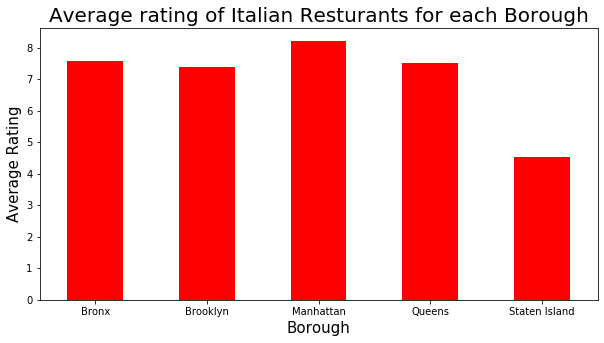

In [25]:
#graphical representation of Averaging rating of ialian restauarants For Each Borough
italian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Italian Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

We will visually map the neighborhoods with an average rating greater than or equal to 8 after joining the approprite dfs to include latitudes and longitudes.

In [26]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
2,Auburndale,8.100000
12,Boerum Hill,9.100000
14,Bushwick,9.400000
15,Carnegie Hill,8.000000
19,City Island,8.200000
22,Clinton Hill,8.550000
23,Cobble Hill,8.500000
25,Concourse Village,8.400000
26,Corona,8.700000
29,Dumbo,8.700000


In [27]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Auburndale,40.761730,-73.791762,8.100000
1,Brooklyn,Boerum Hill,40.685683,-73.983748,9.100000
2,Brooklyn,Bushwick,40.698116,-73.925258,9.400000
3,Manhattan,Carnegie Hill,40.782683,-73.953256,8.000000
4,Bronx,City Island,40.847247,-73.786488,8.200000
5,Brooklyn,Clinton Hill,40.693229,-73.967843,8.550000
6,Brooklyn,Cobble Hill,40.687920,-73.998561,8.500000
7,Bronx,Concourse Village,40.824780,-73.915847,8.400000
8,Queens,Corona,40.742382,-73.856825,8.700000
9,Brooklyn,Dumbo,40.703176,-73.988753,8.700000


In [29]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='red',
            fill_opacity=0.6
        )
    )

In [30]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Finally, we will visualize all NYC buroughs based on average Rating.

In [37]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
    ny_geo = r'Borough Boundaries.geojson'
    ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating')
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

In [ ]:
click <a href= to see the chorpleth map of average ratings